# Twitter Sentiment Analysis: Practice Problem

## Problem Statement

Understanding the problem statement is the first and foremost step. This would help you give an intuition of what you will face ahead of time. Let us see the problem statement -

__*The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.*__

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.

*You can access the problem statement and the data over [here](https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/).*

## Loading Libraries and Data

In [1]:
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200)
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk # for text manipulation
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn import svm
from gensim.models import KeyedVectors
from keras.layers import LSTM, Activation, Dropout, Dense, Input
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Let's read train and test datasets.

In [2]:
train  = pd.read_csv('train.csv', sep=',', header=0)


### Adiciona coluna label com a classificacao mapeada pra rotulos numeros
* 0 = negativo
* 1 = positivo
* 2 = neutro

In [3]:
def label_classificacao(row):
    if row['Classificacao'] == 'Positivo' :
        return 1
    if row['Classificacao'] == 'Negativo' :
        return 0   
    return 2


In [4]:
train['rotulo'] = train.apply(lambda row: label_classificacao(row), axis=1)

In [5]:
test = pd.read_csv('test.csv', sep=',', header=0)

In [6]:
train.head(1)

,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,Observação,Id,rotulo
0,Mon Jan 09 15:27:43 +0000 2017,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG https://t.co/g258J0owsg,NaN,NaN,NaN,Michele #beta #sdv,michelexmbeta,0,Positivo,NaN,6272,1


## Text PreProcessing and Cleaning

### Data Inspection

Let's check out a few non racist/sexist tweets.

In [7]:
train[train['rotulo'] == 0].head(1)

,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,Observação,Id,rotulo
5,Wed Jan 04 23:07:46 +0000 2017,"RT @Silvio_MKT: Fernando Pimentel PISA e COSPE em cima dos mineiros, é impressionante a cara de pau desse sujeito.https://t.co/MSqSlDMRAr",NaN,NaN,"São Paulo, SP",Israel Ziller,IsraelZiller,69,Negativo,NaN,4248,0


<br>
Tweets positivos

In [8]:
train[train['rotulo'] == 1].head(1)

,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,Observação,Id,rotulo
0,Mon Jan 09 15:27:43 +0000 2017,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG https://t.co/g258J0owsg,NaN,NaN,NaN,Michele #beta #sdv,michelexmbeta,0,Positivo,NaN,6272,1


Let's check dimensions of the train and test dataset.

In [9]:
train.shape, test.shape

((6559, 12), (1640, 10))

Train set has 6559 tweets and test set has 1640 tweets.

Let's have a glimpse at label-distribution in the train dataset.

In [10]:
train["rotulo"].value_counts()

1    2639
0    1970
2    1950
Name: rotulo, dtype: int64

<br>
Now we will check the distribution of length of the tweets, in terms of words, in both train and test data.

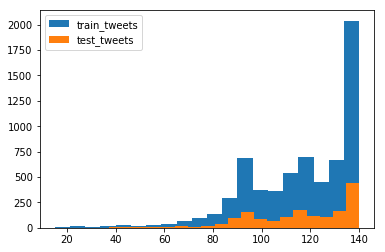

In [11]:
length_train = train['Text'].str.len()
length_test = test['Text'].str.len()

plt.hist(length_train, bins=20, label="train_tweets")
plt.hist(length_test, bins=20, label="test_tweets")
plt.legend()
plt.show()

The tweet-length distribution is more or less the same in both train and test data.


### Data Cleaning

In [12]:
combi = train.append(test, ignore_index=True)
combi.shape

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(8199, 12)

Given below is a user-defined function to remove unwanted text patterns from the tweets.

In [13]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
#         print(input_txt)
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt    

In [14]:
def remove_caracter(input_txt, caracter):
    return input_txt.replace(caracter,)    

__1. Removing Twitter Handles (@user)__

In [15]:
combi['TextLimpo'] = np.vectorize(remove_pattern)(combi['Text'], "@[\w]*") 
combi.head(5)

,Classificacao,Created At,Geo Coordinates.latitude,Geo Coordinates.longitude,Id,Observação,Retweet Count,Text,User Location,User Screen Name,Username,rotulo,TextLimpo
0,Positivo,Mon Jan 09 15:27:43 +0000 2017,NaN,NaN,6272,NaN,0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG https://t.co/g258J0owsg,NaN,michelexmbeta,Michele #beta #sdv,1.0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG https://t.co/g258J0owsg
1,Neutro,Sun Jan 08 02:14:34 +0000 2017,NaN,NaN,1644,NaN,0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semana...qué carajo les pasa ????,Núñez - C.A.B.A.,gabymessina36,Gaby Messina,2.0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semana...qué carajo les pasa ????
2,Positivo,Sat Feb 11 09:49:11 +0000 2017,NaN,NaN,7956,NaN,0,Líderes de motim em presídio de Minas Gerais serão transferidos https://t.co/3ycejsK0yB https://t.co/RrIeOwDV4z,"Hollywood, CA",Wendie_Rower,Wendie Rower,1.0,Líderes de motim em presídio de Minas Gerais serão transferidos https://t.co/3ycejsK0yB https://t.co/RrIeOwDV4z
3,Neutro,Thu Jan 05 14:43:03 +0000 2017,NaN,NaN,85,NaN,0,#Mídia: Press Release from Business Wire : Digital Living Network Alliance - Estado de Minas https://t.co/wj7wMchv8S,SP,binderbr,Marcello Binder,2.0,#Mídia: Press Release from Business Wire : Digital Living Network Alliance - Estado de Minas https://t.co/wj7wMchv8S
4,Positivo,Wed Feb 08 22:52:10 +0000 2017,NaN,NaN,6006,NaN,0,Vacinação contra febre amarela é intensificada na zona rural de Araxá https://t.co/kfaIzOt54Q https://t.co/VnrbOHzFbW,NaN,eufodeu,fodido,1.0,Vacinação contra febre amarela é intensificada na zona rural de Araxá https://t.co/kfaIzOt54Q https://t.co/VnrbOHzFbW


In [16]:
combi['TextLimpo'] = combi['TextLimpo'].str.replace("(", " ")
combi['TextLimpo'] = combi['TextLimpo'].str.replace(")", " ")
combi['TextLimpo'] = combi['TextLimpo'].str.replace("RT", " ")
combi.head(5)

,Classificacao,Created At,Geo Coordinates.latitude,Geo Coordinates.longitude,Id,Observação,Retweet Count,Text,User Location,User Screen Name,Username,rotulo,TextLimpo
0,Positivo,Mon Jan 09 15:27:43 +0000 2017,NaN,NaN,6272,NaN,0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG https://t.co/g258J0owsg,NaN,michelexmbeta,Michele #beta #sdv,1.0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG https://t.co/g258J0owsg
1,Neutro,Sun Jan 08 02:14:34 +0000 2017,NaN,NaN,1644,NaN,0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semana...qué carajo les pasa ????,Núñez - C.A.B.A.,gabymessina36,Gaby Messina,2.0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semana...qué carajo les pasa ????
2,Positivo,Sat Feb 11 09:49:11 +0000 2017,NaN,NaN,7956,NaN,0,Líderes de motim em presídio de Minas Gerais serão transferidos https://t.co/3ycejsK0yB https://t.co/RrIeOwDV4z,"Hollywood, CA",Wendie_Rower,Wendie Rower,1.0,Líderes de motim em presídio de Minas Gerais serão transferidos https://t.co/3ycejsK0yB https://t.co/RrIeOwDV4z
3,Neutro,Thu Jan 05 14:43:03 +0000 2017,NaN,NaN,85,NaN,0,#Mídia: Press Release from Business Wire : Digital Living Network Alliance - Estado de Minas https://t.co/wj7wMchv8S,SP,binderbr,Marcello Binder,2.0,#Mídia: Press Release from Business Wire : Digital Living Network Alliance - Estado de Minas https://t.co/wj7wMchv8S
4,Positivo,Wed Feb 08 22:52:10 +0000 2017,NaN,NaN,6006,NaN,0,Vacinação contra febre amarela é intensificada na zona rural de Araxá https://t.co/kfaIzOt54Q https://t.co/VnrbOHzFbW,NaN,eufodeu,fodido,1.0,Vacinação contra febre amarela é intensificada na zona rural de Araxá https://t.co/kfaIzOt54Q https://t.co/VnrbOHzFbW


__3. Removendo links__

In [17]:
combi['TextLimpo'] = np.vectorize(remove_pattern)(combi['TextLimpo'], r'http\S+') 
combi.head(5)

,Classificacao,Created At,Geo Coordinates.latitude,Geo Coordinates.longitude,Id,Observação,Retweet Count,Text,User Location,User Screen Name,Username,rotulo,TextLimpo
0,Positivo,Mon Jan 09 15:27:43 +0000 2017,NaN,NaN,6272,NaN,0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG https://t.co/g258J0owsg,NaN,michelexmbeta,Michele #beta #sdv,1.0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG
1,Neutro,Sun Jan 08 02:14:34 +0000 2017,NaN,NaN,1644,NaN,0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semana...qué carajo les pasa ????,Núñez - C.A.B.A.,gabymessina36,Gaby Messina,2.0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semana...qué carajo les pasa ????
2,Positivo,Sat Feb 11 09:49:11 +0000 2017,NaN,NaN,7956,NaN,0,Líderes de motim em presídio de Minas Gerais serão transferidos https://t.co/3ycejsK0yB https://t.co/RrIeOwDV4z,"Hollywood, CA",Wendie_Rower,Wendie Rower,1.0,Líderes de motim em presídio de Minas Gerais serão transferidos
3,Neutro,Thu Jan 05 14:43:03 +0000 2017,NaN,NaN,85,NaN,0,#Mídia: Press Release from Business Wire : Digital Living Network Alliance - Estado de Minas https://t.co/wj7wMchv8S,SP,binderbr,Marcello Binder,2.0,#Mídia: Press Release from Business Wire : Digital Living Network Alliance - Estado de Minas
4,Positivo,Wed Feb 08 22:52:10 +0000 2017,NaN,NaN,6006,NaN,0,Vacinação contra febre amarela é intensificada na zona rural de Araxá https://t.co/kfaIzOt54Q https://t.co/VnrbOHzFbW,NaN,eufodeu,fodido,1.0,Vacinação contra febre amarela é intensificada na zona rural de Araxá


__2. Removing Punctuations, Numbers, and Special Characters__

In [18]:
def remover_str_expressao_regular(texto, padrao):
    texto = re.sub(padrao,'', texto)
    return texto

In [19]:
# combi['TextLimpo'] = combi['TextLimpo'].str.replace("[^a-zA-Z#]", " ")
combi['TextLimpo'] = np.vectorize(remover_str_expressao_regular)(combi['TextLimpo'], r'[^\w\s]') 
combi.head(5)

,Classificacao,Created At,Geo Coordinates.latitude,Geo Coordinates.longitude,Id,Observação,Retweet Count,Text,User Location,User Screen Name,Username,rotulo,TextLimpo
0,Positivo,Mon Jan 09 15:27:43 +0000 2017,NaN,NaN,6272,NaN,0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG https://t.co/g258J0owsg,NaN,michelexmbeta,Michele #beta #sdv,1.0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG
1,Neutro,Sun Jan 08 02:14:34 +0000 2017,NaN,NaN,1644,NaN,0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semana...qué carajo les pasa ????,Núñez - C.A.B.A.,gabymessina36,Gaby Messina,2.0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semanaqué carajo les pasa
2,Positivo,Sat Feb 11 09:49:11 +0000 2017,NaN,NaN,7956,NaN,0,Líderes de motim em presídio de Minas Gerais serão transferidos https://t.co/3ycejsK0yB https://t.co/RrIeOwDV4z,"Hollywood, CA",Wendie_Rower,Wendie Rower,1.0,Líderes de motim em presídio de Minas Gerais serão transferidos
3,Neutro,Thu Jan 05 14:43:03 +0000 2017,NaN,NaN,85,NaN,0,#Mídia: Press Release from Business Wire : Digital Living Network Alliance - Estado de Minas https://t.co/wj7wMchv8S,SP,binderbr,Marcello Binder,2.0,Mídia Press Release from Business Wire Digital Living Network Alliance Estado de Minas
4,Positivo,Wed Feb 08 22:52:10 +0000 2017,NaN,NaN,6006,NaN,0,Vacinação contra febre amarela é intensificada na zona rural de Araxá https://t.co/kfaIzOt54Q https://t.co/VnrbOHzFbW,NaN,eufodeu,fodido,1.0,Vacinação contra febre amarela é intensificada na zona rural de Araxá


__4. Remover quebra de linha__

In [20]:
combi['TextLimpo'] = combi['TextLimpo'].str.replace("\n", " ")
combi['TextLimpo'] = combi['TextLimpo'].str.replace("\r", " ")
combi.head(50)

,Classificacao,Created At,Geo Coordinates.latitude,Geo Coordinates.longitude,Id,Observação,Retweet Count,Text,User Location,User Screen Name,Username,rotulo,TextLimpo
0,Positivo,Mon Jan 09 15:27:43 +0000 2017,NaN,NaN,6272,NaN,0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG https://t.co/g258J0owsg,NaN,michelexmbeta,Michele #beta #sdv,1.0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG
1,Neutro,Sun Jan 08 02:14:34 +0000 2017,NaN,NaN,1644,NaN,0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semana...qué carajo les pasa ????,Núñez - C.A.B.A.,gabymessina36,Gaby Messina,2.0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semanaqué carajo les pasa
2,Positivo,Sat Feb 11 09:49:11 +0000 2017,NaN,NaN,7956,NaN,0,Líderes de motim em presídio de Minas Gerais serão transferidos https://t.co/3ycejsK0yB https://t.co/RrIeOwDV4z,"Hollywood, CA",Wendie_Rower,Wendie Rower,1.0,Líderes de motim em presídio de Minas Gerais serão transferidos
3,Neutro,Thu Jan 05 14:43:03 +0000 2017,NaN,NaN,85,NaN,0,#Mídia: Press Release from Business Wire : Digital Living Network Alliance - Estado de Minas https://t.co/wj7wMchv8S,SP,binderbr,Marcello Binder,2.0,Mídia Press Release from Business Wire Digital Living Network Alliance Estado de Minas
4,Positivo,Wed Feb 08 22:52:10 +0000 2017,NaN,NaN,6006,NaN,0,Vacinação contra febre amarela é intensificada na zona rural de Araxá https://t.co/kfaIzOt54Q https://t.co/VnrbOHzFbW,NaN,eufodeu,fodido,1.0,Vacinação contra febre amarela é intensificada na zona rural de Araxá
5,Negativo,Wed Jan 04 23:07:46 +0000 2017,NaN,NaN,4248,NaN,69,"RT @Silvio_MKT: Fernando Pimentel PISA e COSPE em cima dos mineiros, é impressionante a cara de pau desse sujeito.https://t.co/MSqSlDMRAr","São Paulo, SP",IsraelZiller,Israel Ziller,0.0,Fernando Pimentel PISA e COSPE em cima dos mineiros é impressionante a cara de pau desse sujeito
6,Neutro,Mon Jan 09 20:58:13 +0000 2017,NaN,NaN,2938,NaN,607,RT @cyrusxotao: 42- o japão é menor do que o estado de minas gerais. https://t.co/QNLUhWQzIS,merder ♡ hotchniss ♡ vauseman,foryoupompeo,sah kane,2.0,42 o japão é menor do que o estado de minas gerais
7,Negativo,Wed Jan 04 22:55:38 +0000 2017,NaN,NaN,4715,NaN,11,"RT @ZeGeraldo1436: Banco do Brasil cobra de Minas R$ 1,5 bilhão em depósitos judiciais https://t.co/cg3pJa9A5Z",Minas Gerais,Biacerbi,Bia Acerbi,0.0,Banco do Brasil cobra de Minas R 15 bilhão em depósitos judiciais
8,Neutro,Wed Jan 04 22:25:59 +0000 2017,NaN,NaN,2116,NaN,1,Prezado servidor. Sabe seu 13°? Então...\n\n https://t.co/7LG3Fd8Odz,Belo Horizonte,jota_gomes,Juliano Gomes,2.0,Prezado servidor Sabe seu 13 Então
9,Neutro,Wed Jan 04 21:11:03 +0000 2017,NaN,NaN,2579,NaN,27,RT @AnjokaMaximo: #NaoConfiamosNoSTF\nPõe na conta do @STF_oficial \nque não cumpriu seu papel de afastar Pimentel.\no Estado de MG pode cobra…,"Coronel Fabriciano, Brasil",vianadepinho,cida viana,2.0,NaoConfiamosNoSTF Põe na conta do que não cumpriu seu papel de afastar Pimentel o Estado de MG pode cobra


__3. Removing Short Words__

In [22]:
# combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

__5. Carregar lista de stop words__

In [21]:
with open('stopwords.txt') as f:
    content = f.readlines()
stop_words_list = [x.strip() for x in content] 

Let’s take another look at the first few rows of the combined dataframe.

In [120]:
combi.head(20)

,Classificacao,Created At,Geo Coordinates.latitude,Geo Coordinates.longitude,Id,Observação,Retweet Count,Text,User Location,User Screen Name,Username,rotulo,TextLimpo,TextLimpoNorm
0,Positivo,Mon Jan 09 15:27:43 +0000 2017,NaN,NaN,6272,NaN,0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG https://t.co/g258J0owsg,NaN,michelexmbeta,Michele #beta #sdv,1.0,dois detidos tentar jogar celulares drogas presídio mg,dois sã det tent jog celul drog presídi mg
1,Neutro,Sun Jan 08 02:14:34 +0000 2017,NaN,NaN,1644,NaN,0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semana...qué carajo les pasa ????,Núñez - C.A.B.A.,gabymessina36,Gaby Messina,2.0,matan esas minas q cambian 554 veces su foto whatsapp y 628 veces el estado en 1 semanaqué carajo les pasa,matan esas min q cambian 554 vec su fot whatsapp y 628 vec el estad en 1 semanaqu caraj les pas
2,Positivo,Sat Feb 11 09:49:11 +0000 2017,NaN,NaN,7956,NaN,0,Líderes de motim em presídio de Minas Gerais serão transferidos https://t.co/3ycejsK0yB https://t.co/RrIeOwDV4z,"Hollywood, CA",Wendie_Rower,Wendie Rower,1.0,líderes motim presídio minas gerais transferidos,líd motim presídi min ger serã transfer
3,Neutro,Thu Jan 05 14:43:03 +0000 2017,NaN,NaN,85,NaN,0,#Mídia: Press Release from Business Wire : Digital Living Network Alliance - Estado de Minas https://t.co/wj7wMchv8S,SP,binderbr,Marcello Binder,2.0,mídia press release from business wire digital living network alliance estado minas,míd press releas from business wir digital living network allianc estad min
4,Positivo,Wed Feb 08 22:52:10 +0000 2017,NaN,NaN,6006,NaN,0,Vacinação contra febre amarela é intensificada na zona rural de Araxá https://t.co/kfaIzOt54Q https://t.co/VnrbOHzFbW,NaN,eufodeu,fodido,1.0,vacinação contra febre amarela intensificada zona rural araxá,vacin contr febr amarel intensific zon rural arax
5,Negativo,Wed Jan 04 23:07:46 +0000 2017,NaN,NaN,4248,NaN,69,"RT @Silvio_MKT: Fernando Pimentel PISA e COSPE em cima dos mineiros, é impressionante a cara de pau desse sujeito.https://t.co/MSqSlDMRAr","São Paulo, SP",IsraelZiller,Israel Ziller,0.0,fernando pimentel pisa cospe cima mineiros impressionante cara pau desse sujeito,fern pimentel pis cosp cim mineir impression car pau dess sujeit
6,Neutro,Mon Jan 09 20:58:13 +0000 2017,NaN,NaN,2938,NaN,607,RT @cyrusxotao: 42- o japão é menor do que o estado de minas gerais. https://t.co/QNLUhWQzIS,merder ♡ hotchniss ♡ vauseman,foryoupompeo,sah kane,2.0,42 japão menor estado minas gerais,42 japã menor estad min ger
7,Negativo,Wed Jan 04 22:55:38 +0000 2017,NaN,NaN,4715,NaN,11,"RT @ZeGeraldo1436: Banco do Brasil cobra de Minas R$ 1,5 bilhão em depósitos judiciais https://t.co/cg3pJa9A5Z",Minas Gerais,Biacerbi,Bia Acerbi,0.0,banco brasil cobra minas r 15 bilhão depósitos judiciais,banc brasil cobr min r 15 bilhã depósit judic
8,Neutro,Wed Jan 04 22:25:59 +0000 2017,NaN,NaN,2116,NaN,1,Prezado servidor. Sabe seu 13°? Então...\n\n https://t.co/7LG3Fd8Odz,Belo Horizonte,jota_gomes,Juliano Gomes,2.0,prezado servidor sabe 13 então,prez servidor sab 13 entã
9,Neutro,Wed Jan 04 21:11:03 +0000 2017,NaN,NaN,2579,NaN,27,RT @AnjokaMaximo: #NaoConfiamosNoSTF\nPõe na conta do @STF_oficial \nque não cumpriu seu papel de afastar Pimentel.\no Estado de MG pode cobra…,"Coronel Fabriciano, Brasil",vianadepinho,cida viana,2.0,naoconfiamosnostf põe conta cumpriu papel afastar pimentel estado mg pode cobra,naoconfiamosnostf põ cont nã cumpr papel afast pimentel estad mg pod cobr


__4. Text Normalization__

Aqui sera opcionalmente utilizada a normalizacao lexica da spi snowballstemer

In [23]:
# Tokenização
def tokenize_norm(text):
    # Tokenização
    tokens = nltk.word_tokenize(text)
    
    # Stemização
    stems  = []
    for item in tokens:
        stems.append(SnowballStemmer("portuguese").stem(item))
        stems = [stem for stem in stems if not stem in stop_words_list]
    return stems

print(combi['TextLimpo'][0])
print(tokenize_norm(combi['TextLimpo'][0]))

Dois são detidos ao tentar jogar celulares e drogas em presídio de MG  
['dois', 'sã', 'det', 'tent', 'jog', 'celul', 'drog', 'presídi', 'mg']


In [24]:
def tokenize(text):
    # Tokenização
    tokens = nltk.word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in stop_words_list]
    return tokens
print(combi['TextLimpo'][0])
print(tokenize(combi['TextLimpo'][0]))

Dois são detidos ao tentar jogar celulares e drogas em presídio de MG  
['dois', 'detidos', 'tentar', 'jogar', 'celulares', 'drogas', 'presídio', 'mg']


In [25]:
texto_limpo_tokenizado = combi['TextLimpo'].apply(lambda x: tokenize(x)) # tokenizing

In [26]:
texto_limpo_tokenizado.head(1)

0    [dois, detidos, tentar, jogar, celulares, drogas, presídio, mg]
Name: TextLimpo, dtype: object

In [27]:
texto_limpo_norm_tokenizado = combi['TextLimpo'].apply(lambda x: tokenize_norm(x)) # tokenizing

In [28]:
texto_limpo_norm_tokenizado.head(1)

0    [dois, sã, det, tent, jog, celul, drog, presídi, mg]
Name: TextLimpo, dtype: object

Now we can normalize the tokenized tweets.

In [29]:
for i in range(len(texto_limpo_tokenizado)):
    texto_limpo_tokenizado[i] = ' '.join(texto_limpo_tokenizado[i])
    
combi['TextLimpo'] = texto_limpo_tokenizado

for i in range(len(texto_limpo_norm_tokenizado)):
    texto_limpo_norm_tokenizado[i] = ' '.join(texto_limpo_norm_tokenizado[i])
    
combi['TextLimpoNorm'] = texto_limpo_norm_tokenizado

In [30]:
texto_limpo_tokenizado.head(1)

0    dois detidos tentar jogar celulares drogas presídio mg
Name: TextLimpo, dtype: object

In [35]:
train_val_text = combi['TextLimpo'][:6000]
test_text = combi['TextLimpo'][6000:6559]

# splitting data into training and validation set
xtrain_text, xvalid_text, ytrain, yvalid = train_test_split(train_val_text, train['rotulo'][:6000],  
                                                          random_state=42, 
                                                          test_size=0.2)

In [51]:
tokenizer = Tokenizer(num_words=5037)
tokenizer.fit_on_texts(xtrain_text)

words_to_index = tokenizer.word_index

In [52]:
print(xtrain_text[:10])

3897    contra pornografia masturbação deputado propõe projeto barra conteúdo internet politica estado minas
5628                                                     bb avisa justiça governo mg recursos conta judicial
1756                       bb avisa justiça governo mg recursos conta judicial 04012017 mercado folha spaulo
2346                                      governo ainda quer indenizar família bandidos presotemquetrabalhar
2996                       nova rebelião cadeia pública manaus deixa menos três mortos nacional estado minas
1595                       pagamento ipva começa próxima semana guias disponíveis internet secretaria estado
5966                                              fernando pimentel entrega viaturas pm governador valadares
3252                                               1963 adotada bandeira estado minas gerais partzdahistoria
829                                            polícia civil apresenta dupla presa tráfico drogas patrocínio
5864               

In [115]:
model = KeyedVectors.load_word2vec_format('cbow_s300.txt')

In [116]:
print(model['avisa'].shape[0])
print(type(model))

300
<class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>


In [117]:
word_vectors_glove = model.wv

In [149]:
maxLen = 140
vocab_len = len(words_to_index)+1
embed_vector_len = model['avisa'].shape[0]
emb_matrix = np.zeros((vocab_len, embed_vector_len))
qtd_tokens_withou_vector = 0
for word, index in words_to_index.items():
    if word in word_vectors_glove:
        embedding_vector = model[word]
        if embedding_vector is not None:
            emb_matrix[index, :] = embedding_vector
        else:
            qtd_tokens_withou_vector +=1
    else:
        qtd_tokens_withou_vector +=1
print('qtd_tokens_withou_vector: '+str(qtd_tokens_withou_vector))
embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=True)

qtd_tokens_withou_vector: 699


In [150]:
def imdb_rating(input_shape):
    X_indices = Input(input_shape)
    embeddings = embedding_layer(X_indices)
    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.6)(X)
    X = LSTM(128, return_sequences=True)(X)
    X = Dropout(0.6)(X)
    X = LSTM(128)(X)
    X = Dense(3, activation='sigmoid')(X)
    model = Model(inputs=X_indices, outputs=X)
    return model

In [73]:
X_train_indices = tokenizer.texts_to_sequences(xtrain_text)
X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')

In [151]:
lstm_model = imdb_rating((maxLen,))
lstm_model.summary()
adam = keras.optimizers.Adam(lr = 0.0001)
from keras.optimizers import SGD
opt = SGD(lr=0.001)
lstm_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_indices, ytrain, batch_size=128, epochs=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 140)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 140, 300)          1511400   
_________________________________________________________________
lstm_81 (LSTM)               (None, 140, 128)          219648    
_________________________________________________________________
dropout_52 (Dropout)         (None, 140, 128)          0         
_________________________________________________________________
lstm_82 (LSTM)               (None, 140, 128)          131584    
_________________________________________________________________
dropout_53 (Dropout)         (None, 140, 128)          0         
_________________________________________________________________
lstm_83 (LSTM)               (None, 128)               131584    
__________